## 207 -Applied Machine Learning Project: Predicting Attrition of an Online Store Site

#### Authors:

Diego Moss\
Sammy Cayo\
Conor Huh\
Roz Huang\
Jasmine Lau



In [9]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys

## Loading Data from BigQuery and Binding Rows

In [3]:
## code block for initial data loading

from google.colab import auth
from google.cloud import bigquery

def query_data():
  sys.path.append('/content/src/bq-helper')
  from bq_helper import BigQueryHelper
  !pip install -e git+https://github.com/ConorHuh/BigQuery_Helper#egg=bq_helper
  auth.authenticate_user()
  project_id = "final-project-430217" # change this to correct project ID
  client = bigquery.Client(project=project_id)

  google_analytics = BigQueryHelper(active_project="bigquery-public-data",
                                    dataset_name="data:google_analytics_sample",
                                    project_id=project_id)

table_names = []
all_data = []
all_hits_data = []

start_date = datetime(2016, 8, 1)
end_date = datetime(2017, 8, 1)
current_date = start_date
count = 0
while current_date <= end_date:
    table_name = f"ga_sessions_{current_date.strftime('%Y%m%d')}"
    query = f"""
    SELECT *
    FROM `bigquery-public-data.google_analytics_sample.{table_name}`
    """
    table_names.append(table_name)
    df = google_analytics.query_to_pandas(query)

    totals = pd.json_normalize(df['totals'])
    totals.columns = ['total_' + col for col in totals.columns]
    df = pd.concat([df.drop(columns=['totals']), totals], axis=1)

    source = pd.json_normalize(df['trafficSource'])
    source.columns = ['trafficSource_' + col for col in source.columns]
    df = pd.concat([df.drop(columns=['trafficSource']), source], axis=1)

    device = pd.json_normalize(df['device'])
    device.columns = ['device_' + col for col in device.columns]
    df = pd.concat([df.drop(columns=['device']), device], axis=1)

    network = pd.json_normalize(df['geoNetwork'])
    network.columns = ['geoNetwork_' + col for col in network.columns]
    df = pd.concat([df.drop(columns=['geoNetwork']), network], axis=1)

    custom_dimensions = pd.json_normalize(df.explode('customDimensions')['customDimensions'])
    custom_dimensions.columns = ['customDimensions_' + col for col in custom_dimensions.columns]
    df = pd.concat([df.drop(columns=['customDimensions']), custom_dimensions], axis=1)

    df.to_csv(f'{table_name}.csv')
    all_data.append(df)

    hits_df = pd.json_normalize(df.explode('hits')['hits'])
    hit_length = df['hits'].apply(len)
    repeated_visit_ids = pd.DataFrame(np.repeat(df['visitId'].values, df['hits'].apply(len)), columns=['visitID'])

    repeated_visit_ids = pd.DataFrame(np.repeat(df[['visitId', 'fullVisitorId', 'date']].values, 
                                                hit_length, axis=0), 
                                                columns=['visitId', 'fullVisitorId', 'date'])
    hits_df = pd.concat([repeated_visit_ids, hits_df], axis=1)
    # hits_df.to_csv(f'{table_name}_hits.csv')
    all_hits_data.append(hits_df)
    count += 1
    print(f'{count}:366, {current_date}')
    current_date += timedelta(days=1)

final_df = pd.concat(all_data, ignore_index=True)
final_hits_df = pd.concat(all_hits_data, ignore_index=True)

final_df.to_csv('all_data.csv', index=False)
final_hits_df.to_csv('all_hits_data.csv', index=False)
 


# Load Data from Google Drive

In [1]:
# Connect to GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DF_DATA_PATH = '/content/drive/MyDrive/google_analytics_sample/all_data.csv'
HITS_DATA_PATH = '/content/drive/MyDrive/google_analytics_sample/all_hits_data.csv'
def load_final_df(path):
    df = pd.read_csv(path)
    return df
df = load_final_df(DF_DATA_PATH)
hits_df = load_final_df(HITS_DATA_PATH)

<ipython-input-24-e63f5abdcee6>:4: DtypeWarning: Columns (6,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [ ]:
# Debugging...
print(df['date'])
# Convert the 'date' column to string, then to datetime
df['date'] = df['date'].astype(str)
df['date0'] = pd.to_datetime(df['date'], format='%Y%m%d')
print(df['date0'])

df['year_month'] = df['date0'].dt.to_period('M')
print(df['year_month'])

In [25]:
# drop all unnecessary columns from hits_df
columns_to_retain = ['visitId', 'fullVisitorId', 'date', 'eCommerceAction.action_type']
hits_df = hits_df[columns_to_retain]
print(hits_df.head())

# map the eCommerceAction.action_type field to their semantic values
action_type_mapping = {
    1: 'num_product_list_views',
    2: 'num_product_detail_views',
    3: 'num_ATC',
    4: 'num_RFC',
    5: 'num_Checkout',
    6: 'num_Purchase',
    7: 'num_Refund'
}

# Initialize the columns for the result
for action in action_type_mapping.values():
    hits_df[action] = 0

# Aggregate the action_type counts for each group
aggregated_df = hits_df.groupby(['fullVisitorId', 'date']).agg( # group only by visitorID and date
    num_product_list_views=('eCommerceAction.action_type', lambda x: (x == 1).sum()),
    num_product_detail_views=('eCommerceAction.action_type', lambda x: (x == 2).sum()),
    num_ATC=('eCommerceAction.action_type', lambda x: (x == 3).sum()),
    num_RFC=('eCommerceAction.action_type', lambda x: (x == 4).sum()),
    num_Checkout=('eCommerceAction.action_type', lambda x: (x == 5).sum()),
    num_Purchase=('eCommerceAction.action_type', lambda x: (x == 6).sum()),
    num_Refund=('eCommerceAction.action_type', lambda x: (x == 7).sum())
).reset_index()

print(aggregated_df.head())


0         20160801
1         20160801
2         20160801
3         20160801
4         20160801
            ...   
903648    20170801
903649    20170801
903650    20170801
903651    20170801
903652    20170801
Name: date, Length: 903653, dtype: int64
0        2016-08-01
1        2016-08-01
2        2016-08-01
3        2016-08-01
4        2016-08-01
            ...    
903648   2017-08-01
903649   2017-08-01
903650   2017-08-01
903651   2017-08-01
903652   2017-08-01
Name: date0, Length: 903653, dtype: datetime64[ns]
0         2016-08
1         2016-08
2         2016-08
3         2016-08
4         2016-08
           ...   
903648    2017-08
903649    2017-08
903650    2017-08
903651    2017-08
903652    2017-08
Name: year_month, Length: 903653, dtype: period[M]
      visitId       fullVisitorId      date  eCommerceAction.action_type
0  1470046245  895954260133011192  20160801                            0
1  1470046245  895954260133011192  20160801                            0
2  14700462

<ipython-input-25-8ed82fdf3432>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits_df[action] = 0
<ipython-input-25-8ed82fdf3432>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits_df[action] = 0
<ipython-input-25-8ed82fdf3432>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

    fullVisitorId      date  num_product_list_views  num_product_detail_views  \
0   4823595352351  20161101                       0                         0   
1   5103959234087  20160821                       1                         1   
2  10278554503158  20161020                       3                         2   
3  20424342248747  20161130                       3                         3   
4  27376579751715  20170211                       1                         1   

   num_ATC  num_RFC  num_Checkout  num_Purchase  num_Refund  
0        0        0             0             0           0  
1        0        0             0             0           0  
2        0        0             0             0           0  
3        0        0             0             0           0  
4        0        0             0             0           0  


In [30]:
# Sanity Check to make sure we haven't lost data
print(aggregated_df.shape)
print(len(aggregated_df['fullVisitorId'].unique())) # 566,477
print(len(hits_df['fullVisitorId'].unique())) # 566,477
print(len(hits_df['visitId'].unique())) #694,649
print(len(df['fullVisitorId'].unique())) # 718,161
print(df.columns)


(657599, 9)
566477
566477
694649
718161
Index(['visitorId', 'visitNumber', 'visitId', 'visitStartTime', 'date', 'hits',
       'fullVisitorId', 'userId', 'channelGrouping', 'socialEngagementType',
       'total_visits', 'total_hits', 'total_pageviews', 'total_timeOnSite',
       'total_bounces', 'total_transactions', 'total_transactionRevenue',
       'total_newVisits', 'total_screenviews', 'total_uniqueScreenviews',
       'total_timeOnScreen', 'total_totalTransactionRevenue',
       'total_sessionQualityDim', 'trafficSource_referralPath',
       'trafficSource_campaign', 'trafficSource_source',
       'trafficSource_medium', 'trafficSource_keyword',
       'trafficSource_adContent', 'trafficSource_isTrueDirect',
       'trafficSource_campaignCode',
       'trafficSource_adwordsClickInfo.campaignId',
       'trafficSource_adwordsClickInfo.adGroupId',
       'trafficSource_adwordsClickInfo.creativeId',
       'trafficSource_adwordsClickInfo.criteriaId',
       'trafficSource_adwordsCli

In [41]:
# Merge the two dfs:

# Convert the two dataframe fullVisitorId and date fields to matching types
df['fullVisitorId'] = df['fullVisitorId'].astype(str)
aggregated_df['fullVisitorId'] = aggregated_df['fullVisitorId'].astype(str)
df['date'] = df['date'].astype(str)
aggregated_df['date'] = aggregated_df['date'].astype(str)

# Merge
df_merged = pd.merge(df, aggregated_df, on=['fullVisitorId', 'date'], how='left')

# Fill empty columns with 0 rather than dropping
action_columns = ['num_product_list_views', 'num_product_detail_views', 'num_ATC', 'num_RFC', 'num_Checkout', 'num_Purchase', 'num_Refund']
df_merged[action_columns] = df_merged[action_columns].fillna(0)
df_merged.head()


,visitorId,visitNumber,visitId,visitStartTime,date,hits,fullVisitorId,userId,channelGrouping,socialEngagementType,...,clientId,date0,year_month,num_product_list_views,num_product_detail_views,num_ATC,num_RFC,num_Checkout,num_Purchase,num_Refund
0,NaN,1,1470046245,1470046245,20160801,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",895954260133011192,NaN,Organic Search,Not Socially Engaged,...,NaN,2016-08-01,2016-08,7.0,4.0,0.0,0.0,0.0,0.0,0.0
1,NaN,1,1470084717,1470084717,20160801,"[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",288478011259077136,NaN,Direct,Not Socially Engaged,...,NaN,2016-08-01,2016-08,4.0,2.0,0.0,0.0,0.0,0.0,0.0
2,NaN,3,1470078988,1470078988,20160801,"[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",6440789996634275026,NaN,Organic Search,Not Socially Engaged,...,NaN,2016-08-01,2016-08,10.0,7.0,0.0,0.0,0.0,0.0,0.0
3,NaN,4,1470075581,1470075581,20160801,"[{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...",8520115029387302083,NaN,Referral,Not Socially Engaged,...,NaN,2016-08-01,2016-08,2.0,2.0,2.0,2.0,0.0,0.0,0.0
4,NaN,30,1470099026,1470099026,20160801,"[{'hitNumber': 1, 'time': 0, 'hour': 17, 'minu...",6792260745822342947,NaN,Organic Search,Not Socially Engaged,...,NaN,2016-08-01,2016-08,10.0,5.0,0.0,0.0,0.0,0.0,0.0


In [42]:
from sklearn.preprocessing import LabelEncoder

# Convert 'date' to datetime format and extract year and month
df_merged['date'] = df_merged['date'].astype(str)
df_merged['date'] = pd.to_datetime(df_merged['date'], format='%Y%m%d')
df_merged['year_month'] = df_merged['date'].dt.to_period('M')
print(df_merged['year_month'])

# Sort the dataframe
df_merged = df_merged.sort_values(by=['fullVisitorId', 'year_month'])

# Define feature columns
feature_columns = [
    "fullVisitorId",
    "visitNumber",
    "year_month",
    "total_hits",
    "total_pageviews",
    "total_screenviews",
    "total_sessionQualityDim",
    "total_timeOnSite",
    "total_totalTransactionRevenue",
    "total_transactions",
    "trafficSource_source",
    "socialEngagementType",
    "channelGrouping",
    "device_browser",
    "device_operatingSystem",
    "device_deviceCategory",
    "geoNetwork_continent",
    "geoNetwork_subContinent",
    "geoNetwork_country",
    "geoNetwork_region",
    "geoNetwork_metro",
    "geoNetwork_city",
    "num_product_list_views",
    "num_product_detail_views",
    'num_ATC',
    'num_RFC',
    'num_Checkout',
    'num_Purchase',
    'num_Refund'
]

df_merged = df_merged[feature_columns]

# Define numeric and non-numeric columns
numeric_columns = [
    "visitNumber",
    "total_hits",
    "total_pageviews",
    "total_screenviews",
    "total_sessionQualityDim",
    "total_timeOnSite",
    "total_totalTransactionRevenue",
    "total_transactions",
    "num_product_list_views",
    "num_product_detail_views",
    'num_ATC',
    'num_RFC',
    'num_Checkout',
    'num_Purchase',
    'num_Refund'
]

non_numeric_columns = [
    "trafficSource_source",
    "socialEngagementType",
    "channelGrouping",
    "device_browser",
    "device_operatingSystem",
    "device_deviceCategory",
    "geoNetwork_continent",
    "geoNetwork_subContinent",
    "geoNetwork_country",
    "geoNetwork_region",
    "geoNetwork_metro",
    "geoNetwork_city",
]

# Encode non-numeric columns
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    df_merged[col] = le.fit_transform(df_merged[col].astype(str))
    label_encoders[col] = le

# Aggregate data by 'fullVisitorId' and 'year_month'
agg_funcs = {col: 'sum' for col in numeric_columns}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_columns})

df_agg = df_merged.groupby(['fullVisitorId', 'year_month']).agg(agg_funcs).reset_index()

unique_users = df_agg['fullVisitorId'].unique()
unique_year_months = df_agg['year_month'].unique()

# - 2 because fullVisitorId and year_month are not features
array_shape = (len(unique_users), len(feature_columns) - 2, len(unique_year_months))
array_3d = np.zeros(array_shape, dtype=np.float32)

# Create a dictionary to map fullVisitorId and year_month to index
user_index = {user: i for i, user in enumerate(unique_users)}
date_index = {date: j for j, date in enumerate(unique_year_months)}

for row in df_agg.itertuples(index=False):
    user_idx = user_index[row.fullVisitorId]
    date_idx = date_index[row.year_month]

    # Numeric values
    array_3d[user_idx, 0:len(numeric_columns), date_idx] = [getattr(row, col) for col in numeric_columns]

    # Non-numeric values
    array_3d[user_idx, len(numeric_columns):, date_idx] = [getattr(row, col) for col in non_numeric_columns]

print(array_3d.shape)
print(array_3d.nbytes)
print(array_3d)

0         2016-08
1         2016-08
2         2016-08
3         2016-08
4         2016-08
           ...   
903760    2017-08
903761    2017-08
903762    2017-08
903763    2017-08
903764    2017-08
Name: year_month, Length: 903765, dtype: period[M]
(714584, 27, 13)
1003275936
[[[  1.   0.   0. ...   0.   0.   0.]
  [  3.   0.   0. ...   0.   0.   0.]
  [  3.   0.   0. ...   0.   0.   0.]
  ...
  [ 57.   0.   0. ...   0.   0.   0.]
  [ 47.   0.   0. ...   0.   0.   0.]
  [316.   0.   0. ...   0.   0.   0.]]

 [[ 10.   0.   0. ...   0.   0.   0.]
  [  1.   0.   0. ...   0.   0.   0.]
  [  1.   0.   0. ...   0.   0.   0.]
  ...
  [ 57.   0.   0. ...   0.   0.   0.]
  [ 78.   0.   0. ...   0.   0.   0.]
  [366.   0.   0. ...   0.   0.   0.]]

 [[  0.   1.   0. ...   0.   0.   0.]
  [  0.   1.   0. ...   0.   0.   0.]
  [  0.   1.   0. ...   0.   0.   0.]
  ...
  [  0. 101.   0. ...   0.   0.   0.]
  [  0.  46.   0. ...   0.   0.   0.]
  [  0. 314.   0. ...   0.   0.   0.]]

 ...

 [[  0.  

In [ ]:
# Save features to GDrive
np.save('/content/drive/MyDrive/google_analytics_sample/features_with_hits.npy', array_3d)

In [ ]:
features_with_hits = np.load('/content/drive/MyDrive/google_analytics_sample/features_with_hits.npy')

In [ ]:
print(features_with_hits.shape)
print(features_with_hits[0])
stable_features = np.mean(features_with_hits, axis=2)
print(stable_features.shape)
print(stable_features[0])

In [ ]:
np.save('/content/drive/MyDrive/google_analytics_sample/stable_features.npy', stable_features)

## Initial Data Pre-Processing and Feature Extraction

In [ ]:
## code block for preprocessing

## after binding rows we will need to extract the data from the columns with multiple data and put into their own columns

## should code categorical variables into one-encoding

## we need to manipulate and aggregate each user's data for each month for all the manipulated features in our list

## we should take a look at how bad we're missing data and decide for imputation or removal




## shaping the data in the right way for the LSTM model (3 dimensions)

def create_sequences(df, sequence_length):
    sequences = []
    targets = []
    user_ids = df['user_id'].unique()

    for user_id in user_ids:
        user_data = df[df['user_id'] == user_id]
        user_data = user_data.sort_values(by='month')  # Ensure data is sorted by time
        for i in range(len(user_data) - sequence_length):
            seq = user_data.iloc[i:i+sequence_length].drop(columns=['user_id', 'days_until_next_visit']).values # target can change depending on our attrition statistics
            target = user_data.iloc[i+sequence_length]['days_until_next_visit'] # target can change depending on our attrition statistics
            sequences.append(seq)
            targets.append(target)

    return sequences, np.array(targets)

# 12 months
sequence_length = 12

# creating our sequences and targets for putting into X and y objects
data_sequences, targets = create_sequences(df, sequence_length)

# Pad sequences to ensure all have the same length
data_sequences_padded = pad_sequences(data_sequences, maxlen=sequence_length, padding='post', dtype='float32')

# Convert to arrays and saving as X and y
X = np.array(data_sequences_padded)
y = np.array(targets)



## Create Binary Target Variable

In [10]:
DF_DATA_PATH = '../features_with_hits.npy'
data = np.load(DF_DATA_PATH)
data.shape

(714584, 27, 13)

In [11]:
num_users, num_months = data.shape[0], data.shape[2]

y = np.zeros((num_users, num_months), dtype=int)

for month_idx in range(num_months - 1):    
    # Check if there is any non-zero activity in the subsequent months
    subsequent_activity = np.any(data[:, :, month_idx + 1:] > 0, axis=(1, 2))
    y[:, month_idx] = subsequent_activity.astype(int)

print(y.shape)

(714584, 13)


Class Distribution: {0: 5424667, 1: 3864925}


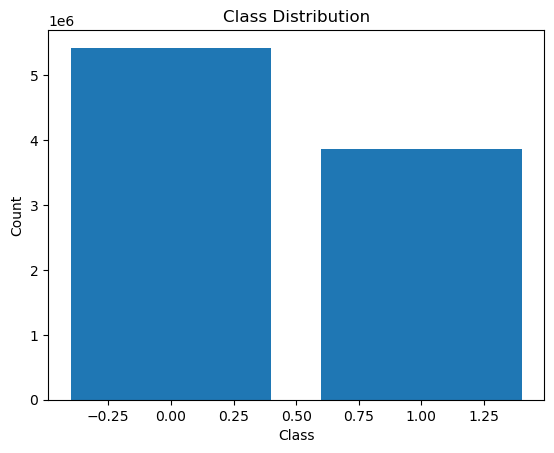

In [12]:
num_users, num_months = y.shape
flattened_y = y.flatten()

# Count occurrences of each class
unique, counts = np.unique(flattened_y, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution:", class_distribution)

plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

Month 0: {0: 47032, 1: 667552}
Month 1: {0: 103733, 1: 610851}
Month 2: {0: 151277, 1: 563307}
Month 3: {0: 243878, 1: 470706}
Month 4: {0: 304802, 1: 409782}
Month 5: {0: 385763, 1: 328821}
Month 6: {0: 439133, 1: 275451}
Month 7: {0: 495313, 1: 219271}
Month 8: {0: 556604, 1: 157980}
Month 9: {0: 609313, 1: 105271}
Month 10: {0: 660944, 1: 53640}
Month 11: {0: 712291, 1: 2293}
Month 12: {0: 714584}


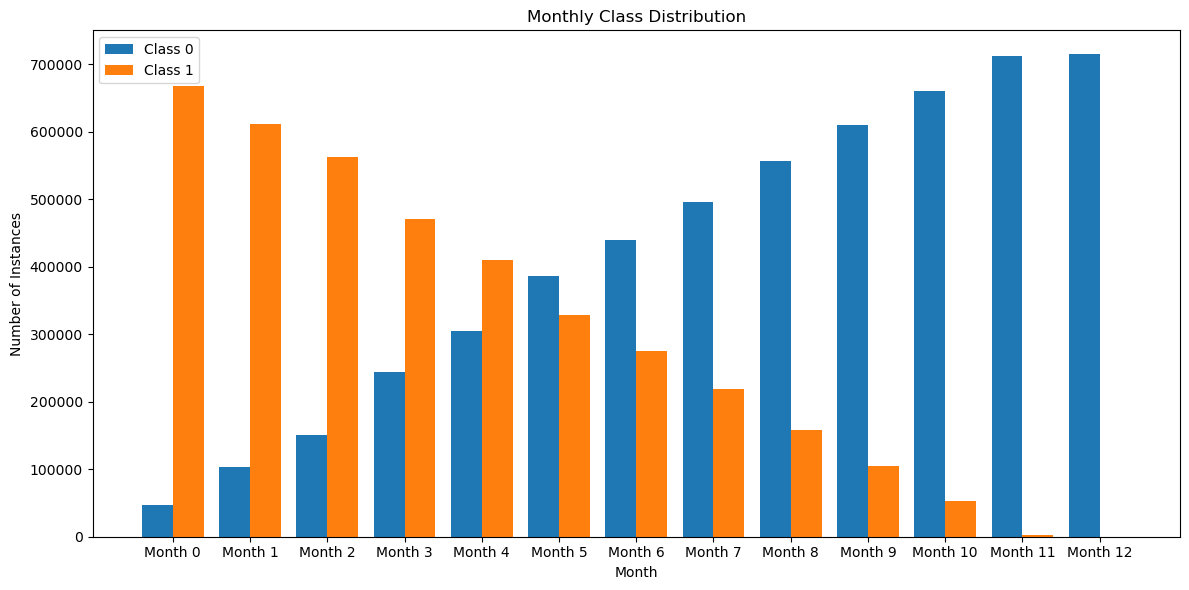

In [13]:
# Count occurrences of each class for each month
monthly_class_distribution = {}

for month_idx in range(num_months):
    month_labels = y[:, month_idx]
    unique, counts = np.unique(month_labels, return_counts=True)
    monthly_class_distribution[month_idx] = dict(zip(unique, counts))

# Print monthly class distributions
for month, distribution in monthly_class_distribution.items():
    print(f"Month {month}: {distribution}")

# Extract data from the dictionary
months = list(monthly_class_distribution.keys())
class_0_counts = [monthly_class_distribution[month].get(0, 0) for month in months]
class_1_counts = [monthly_class_distribution[month].get(1, 0) for month in months]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
index = np.arange(len(months))
bar1 = ax.bar(index - bar_width/2, class_0_counts, bar_width, label='Class 0')
bar2 = ax.bar(index + bar_width/2, class_1_counts, bar_width, label='Class 1')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Instances')
ax.set_title('Monthly Class Distribution')
ax.set_xticks(index)
ax.set_xticklabels([f'Month {i}' for i in months])
ax.legend()
plt.tight_layout()
plt.show()

## Splitting Data

In [ ]:
## splitting data code block

## need to see distribution of target variable and distribution of months in the data. If unequal need to sample so that the training set has roughly equal targets and months

## may need to manually split the data, make sure we are splitting by user and not by month


## More Data Processing and EDA

In [ ]:
from sklearn.preprocessing import StandardScaler


## EDA - visualizing distributions and correlations


    # histograms for each feature


    # correlations matrix/plot/heatmap






## standardizing features based on the training distributions



# defining lists of indices for the numerical and categorical features and telling it to ignore one-hot encoded variables

# replace with indices for all the numeric columns to be standardized (need to calculate which indices after flattening from 3d to 2d)
numerical_features_indices = [None,None]

# replace with indices for all the one-hot encoded columns to be ignored (need to calculate which indices after flattening from 3d to 2d)
one_hot_encoded_indices = [None,None]




# making a preprocessor to standardize and ignore features (also this is were we can impute data if we'd like)
numerical_transformer = Pipeline(steps=[ # this says to do the below manipulations to each specified column
    ('imputer', SimpleImputer(strategy='median')),  # This is the handling of missing values, placeholder for now
    ('scaler', StandardScaler()) # this standardizes
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer( # this takes the pipeline from before and maps which columns to apply the numerical transformations
    transformers=[
        ('num', numerical_transformer, numerical_features_indices),
        ('cat', 'passthrough', one_hot_encoded_indices)
    ]
)



# fitting on 2d reshaped X_train because the scaler won't work on 3 dimensions, then returning back into 3 dimensions
X_train = preprocessor.fit_transform(X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[-1])).reshape(X_train.shape)
# doing same for test set
X_test = preprocessor.transform(X_test.reshape(X_train.shape[0]*X_train.shape[1], X_test.shape[-1])).reshape(X_test.shape)




## Model Fitting and Architecture

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, TimeDistributed


# may need to turn this into a function so we can use in hyperparameter tuning


## Defining Model

# need to separate the stable features from the dynamic features fix this once we know which features
X_train_dynamic = None
X_train_stable = None


# Input for dynamic features
dynamic_input = Input(shape=(X_train_dynamic.shape[1], X_train_dynamic.shape[2]))
x = LSTM(units=50, return_sequences=True)(dynamic_input) # the parantheses here are telling the function to apply only to the dynamic features


# Input for stable features
stable_input = Input(shape=(X_train_stable.shape[1],))
stable_repeated = Dense(X_train_dynamic.shape[1])(stable_input)
stable_repeated = RepeatVector(X_train_dynamic.shape[1])(stable_repeated)
stable_repeated = TimeDistributed(Dense(50))(stable_repeated)


# Concatenate LSTM output with stable features
x = Concatenate()([x, stable_input])

# TimeDistributed Dense layer to get prediction for each timestep
output = TimeDistributed(Dense(1, activation='sigmoid'))(x)

# Define the model
model = Model(inputs=[dynamic_input, stable_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy', 'precision'])
# should look as precision because we care more about correctly catching attrition over falsely claiming someone will attrit

# Train the model
model.fit([X_train_dynamic, X_train_stable], y_train_scaled, epochs=10, validation_split=0.2)



## Hyperparameter Tuning

In [ ]:
## placeholder

## we need to see how long it takes to fit one epoch, then do some math to see how many sets of hyperparameters we can test

## Evaluation Metrics

In [ ]:
## placeholder